# Segmenting and Clustering Neighborhoods in Toronto

## Question 1 - Scraping Wikipedia Page

We scrape the Wikipedia page of postal codes in Canada and assume the first table is the table of interest.

In [1]:
from bs4 import BeautifulSoup
import pandas as pd
import requests

response = requests.get(r'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M')
soup = BeautifulSoup(response.text, 'html.parser')
table = soup.findAll('table')[0]
df = pd.read_html(str(table))[0]

We rename columns, drop not assigned burrows and collapse neighbourhoods into Postal Codes and burrows. 
If some multi neighborhoods are already expressed with a slash, clean it up and replace with a comma

In [2]:
# Rename columns as requested
df.columns = ['PostalCode', 'Borough', 'Neighborhood']

# Drop unassigned boroughs as requested
df = df[df['Borough'] != 'Not assigned']

# Combine neighborhoods with commas
pt = pd.pivot_table(df, index=['PostalCode', 'Borough'], values='Neighborhood', aggfunc=','.join).reset_index()
pt['Neighborhood'] = pt['Neighborhood'].str.replace(' / ', ', ')

In [3]:
# Display in the same order as requested
df_summary = pt.set_index('PostalCode').loc[
    ['M5G', 'M2H', 'M4B', 'M1J', 'M4G', 'M4M', 'M1R', 'M9V', 'M9L', 'M5V', 'M1B', 'M5A']
].reset_index()
df_summary

,PostalCode,Borough,Neighborhood
0,M5G,Downtown Toronto,Central Bay Street
1,M2H,North York,Hillcrest Village
2,M4B,East York,"Parkview Hill, Woodbine Gardens"
3,M1J,Scarborough,Scarborough Village
4,M4G,East York,Leaside
5,M4M,East Toronto,Studio District
6,M1R,Scarborough,"Wexford, Maryvale"
7,M9V,Etobicoke,"South Steeles, Silverstone, Humbergate, Jamest..."
8,M9L,North York,Humber Summit
9,M5V,Downtown Toronto,"CN Tower, King and Spadina, Railway Lands, Har..."


Check how many entries we have

In [4]:
print(pt.shape)

(103, 3)


In [5]:
print(df_summary.shape)

(12, 3)


## Question 2 - Geocoding

In [6]:
def get_lat_lng_coords_from_geocoder(postal_code):
    """ This is using the geocoder api but it is not reliable so we keep retrying until it works. """
    import geocoder
    
    # initialize your variable to None
    lat_lng_coords = None

    # loop until you get the coordinates
    while(lat_lng_coords is None):
      g = geocoder.google('{}, Toronto, Ontario'.format(postal_code))
      lat_lng_coords = g.latlng

    return lat_lng_coords

If it still does not work then we load a cache of data that we've been provided

In [7]:
gps_data_cache = pd.read_csv(r'https://cocl.us/Geospatial_data')

In [8]:
gps_data_cache

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476
...,...,...,...
98,M9N,43.706876,-79.518188
99,M9P,43.696319,-79.532242
100,M9R,43.688905,-79.554724
101,M9V,43.739416,-79.588437


In [9]:
pd.merge(df_summary, gps_data_cache.rename(columns={'Postal Code': 'PostalCode'}), how='left')

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383
1,M2H,North York,Hillcrest Village,43.803762,-79.363452
2,M4B,East York,"Parkview Hill, Woodbine Gardens",43.706397,-79.309937
3,M1J,Scarborough,Scarborough Village,43.744734,-79.239476
4,M4G,East York,Leaside,43.709060,-79.363452
5,M4M,East Toronto,Studio District,43.659526,-79.340923
6,M1R,Scarborough,"Wexford, Maryvale",43.750072,-79.295849
7,M9V,Etobicoke,"South Steeles, Silverstone, Humbergate, Jamest...",43.739416,-79.588437
8,M9L,North York,Humber Summit,43.756303,-79.565963
9,M5V,Downtown Toronto,"CN Tower, King and Spadina, Railway Lands, Har...",43.628947,-79.394420


## Creating a map of Toronto

### Use geopy library to get the latitude and longitude of Toronto

In [11]:
from geopy import Nominatim
address = 'Toronto City, Ontario'

geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geographical coordinate of Toronto City are {}, {}.'.format(latitude, longitude))

The geographical coordinate of Toronto City are 43.6534817, -79.3839347.


#### Create a map of Toronto City with neighborhoods superimposed on top.

##### Only look at boroughs containing 'Toronto'

In [18]:
neighborhoods = pd.merge(pt, gps_data_cache.rename(columns={'Postal Code': 'PostalCode'}), how='left')
neighborhoods = neighborhoods[neighborhoods['Borough'].str.contains('Toronto')]
neighborhoods

,PostalCode,Borough,Neighborhood,Latitude,Longitude
37,M4E,East Toronto,The Beaches,43.676357,-79.293031
41,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188
42,M4L,East Toronto,"India Bazaar, The Beaches West",43.668999,-79.315572
43,M4M,East Toronto,Studio District,43.659526,-79.340923
44,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790
45,M4P,Central Toronto,Davisville North,43.712751,-79.390197
46,M4R,Central Toronto,North Toronto West,43.715383,-79.405678
47,M4S,Central Toronto,Davisville,43.704324,-79.388790
48,M4T,Central Toronto,"Moore Park, Summerhill East",43.689574,-79.383160
49,M4V,Central Toronto,"Summerhill West, Rathnelly, South Hill, Forest...",43.686412,-79.400049


In [23]:
import folium 

# create map of Ontario using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

We can see that the boroughs cluster around the coast, almost with a rotated T shape. The largest cluster happens closet near the water and just near the unvirsity.

Note that it appears sometimes the image does not show up in github, below is a static screen grab of the image.

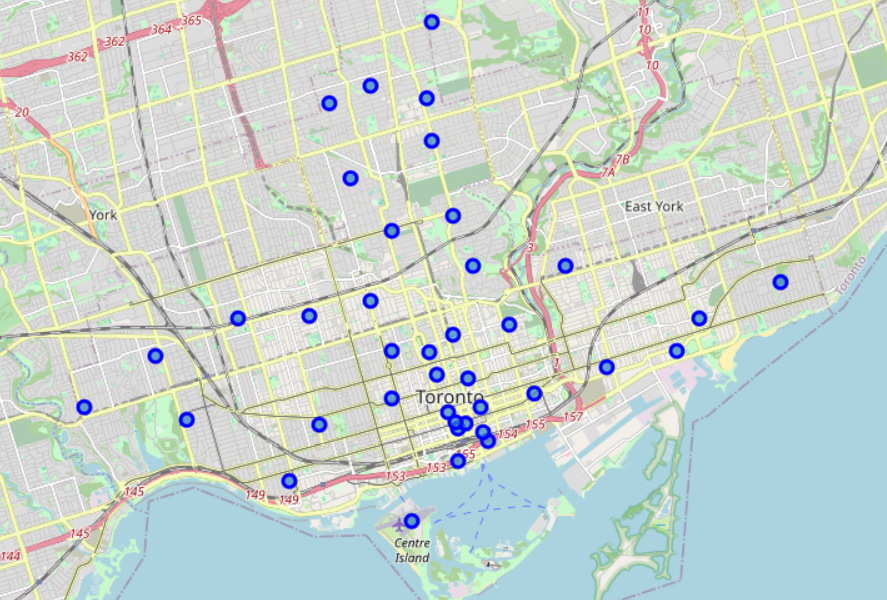

In [24]:
from IPython.display import Image
Image("Annotation 2020-05-06 000651.png")